In [1]:
# Install transformers and graphviz
%%capture
!sudo apt-get install graphviz graphviz-dev
!pip install transformers pygraphviz

# Make sure we're using UTF-8 as encoding
import locale

locale.getpreferredencoding = lambda: "UTF-8"

import time

# Set seed for reproducibility
import torch

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Loading models

In [2]:
from transformers import AutoTokenizer, BloomForCausalLM
import torch

# You can choose other models rather than bloom-560m.
# This model was chosen to fit the Colab requirements.
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")
model = BloomForCausalLM.from_pretrained("bigscience/bloom-560m").to(device)

model.eval()

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250880, 1024)
    (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
          (dense): Linear(in_features=1024, out_features=1024, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (

### Specifying input text and number of tokens to generate

In [3]:
text = "Paris is the city"
NUMBER_OF_OUTPUTS = 5

### Running text-generation out of the box

In [4]:
input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
outputs = model.generate(
    input_ids, max_length=len(input_ids.squeeze()) + NUMBER_OF_OUTPUTS
)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Generated text: {generated_text}")

Generated text: Paris is the city of the future. The


### Function for plot display

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap


def plot_graph(graph, length, beams, score, args=""):
    """
    Plot the graph with nodes colored based on scores.

    Parameters:
        graph (nx.DiGraph): The graph to be plotted.
        length (int): The length of the graph (number of steps).
        beams (float): Beams parameter for plot size calculation.
        score (str): Score type, either 'token' or 'sequence'.
        cmap_name (str, optional): The name of the colormap. Defaults to 'rg'.
    """

    width, height = 3 + 1.2 * beams**length, max(4, 2 + length)
    if args == '-Grankdir="LR"':
        height = 2
    fig, ax = plt.subplots(figsize=(width, height), dpi=300, facecolor="white")

    # Create positions for each node
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot", args=args)

    # Determine the data key based on the score type
    score_key = "tokenscore" if score == "token" else "sequencescore"

    # Extract scores and compute normalization parameters
    node_data = graph.nodes(data=True)
    scores = [data[score_key] for _, data in node_data if data["token"] is not None]
    vmin, vmax = min(scores), max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # Create a colormap with three colors
    cmap = LinearSegmentedColormap.from_list("rg", ["r", "y", "g"], N=256)

    # Draw the nodes with colors based on their scores
    node_colors = [
        data[score_key] for _, data in node_data if data["token"] is not None
    ]

    nx.draw_networkx_nodes(
        graph,
        pos,
        node_size=2000,
        node_shape="o",
        alpha=1,
        linewidths=4,
        node_color=node_colors,
        cmap=cmap,
    )

    # Draw the edges
    nx.draw_networkx_edges(graph, pos)

    # Prepare node labels based on the score type
    label_format = "{:.2f}%" if score == "token" else "{:.2f}"
    labels = {
        node: f"{data['token'].split('_')[0]}\n{label_format.format(data[score_key])}"
        for node, data in node_data
        if data["token"] is not None
    }

    # Draw the labels
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.box(False)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    label_text = "Token probability (%)" if score == "token" else "Sequence score"
    fig.colorbar(sm, ax=ax, orientation="vertical", pad=0, label=label_text)

    plt.show()

## Greedy Search

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch

# Constant variable for the number of outputs
NUMBER_OF_OUTPUTS = 5


def create_graph(text):
    """
    Create a balanced tree with height 'NUMBER_OF_OUTPUTS' and add attributes to nodes.

    Parameters:
        text (str): The text to be used as the 'token' attribute for each node.

    Returns:
        nx.DiGraph: The created graph.
    """
    graph = nx.balanced_tree(1, NUMBER_OF_OUTPUTS, create_using=nx.DiGraph())
    for node in graph.nodes:
        graph.nodes[node].update({"tokenscore": 100, "token": text})
    return graph


def get_top_tokens_and_prob(probabilities, n=5):
    """
    Get the top tokens and their probabilities from the given probabilities tensor.

    Parameters:
        probabilities (torch.Tensor): Tensor containing probabilities for each token.
        n (int, optional): Number of top tokens to retrieve. Defaults to 5.

    Returns:
        list: List of tuples containing top tokens and their corresponding probabilities.
    """
    sorted_indices = torch.topk(probabilities, n).indices
    token_probs = [
        (tokenizer.decode(idx.item()), probabilities[idx].item())
        for idx in sorted_indices
    ]
    return token_probs


def greedy_search(input_ids, node, length=5, graph=None):
    """
    Recursive function for greedy search.

    Parameters:
        input_ids (torch.Tensor): Tensor containing input token IDs.
        node (int): Current node index in the graph.
        length (int, optional): Length of generated text. Defaults to 5.
        graph (nx.DiGraph, optional): Graph representing the text generation tree. Defaults to None.

    Returns:
        torch.Tensor: Tensor containing the generated text token IDs.
    """
    if length == 0:
        return input_ids

    outputs = model(input_ids)
    logits = outputs.logits[0, -1, :]
    probabilities = torch.softmax(logits, dim=-1)

    # Find the most probable token and its log probability
    token_id = torch.argmax(probabilities).unsqueeze(0)
    token_score = torch.log(probabilities[token_id])

    new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0)], dim=-1)
    next_token = tokenizer.decode(token_id, skip_special_tokens=True)
    current_node = next(iter(graph.successors(node)))
    graph.nodes[current_node].update(
        {
            "tokenscore": np.exp(token_score.item()) * 100,
            "token": f"{next_token}_{length}",
        }
    )

    return greedy_search(new_input_ids, current_node, length - 1, graph=graph)


def run_greedy(text):
    """
    Run greedy text generation.

    Parameters:
        input_ids (torch.Tensor): Tensor containing input token IDs.

    Returns:
        tuple: A tuple containing the generated text and the graph.
    """
    input_ids = tokenizer.encode(text, return_tensors="pt").to(device)

    # Beams parameter will be explained in the next section
    beams = 1

    # Creating graph
    graph = create_graph(text)

    # Start generating text
    output_ids = greedy_search(input_ids, 0, length=NUMBER_OF_OUTPUTS, graph=graph)
    output = tokenizer.decode(output_ids.squeeze().tolist(), skip_special_tokens=True)
    return output, graph


output, graph = run_greedy(text)
print(f"Generated text: {output}")

Generated text: Paris is the city of the future. The


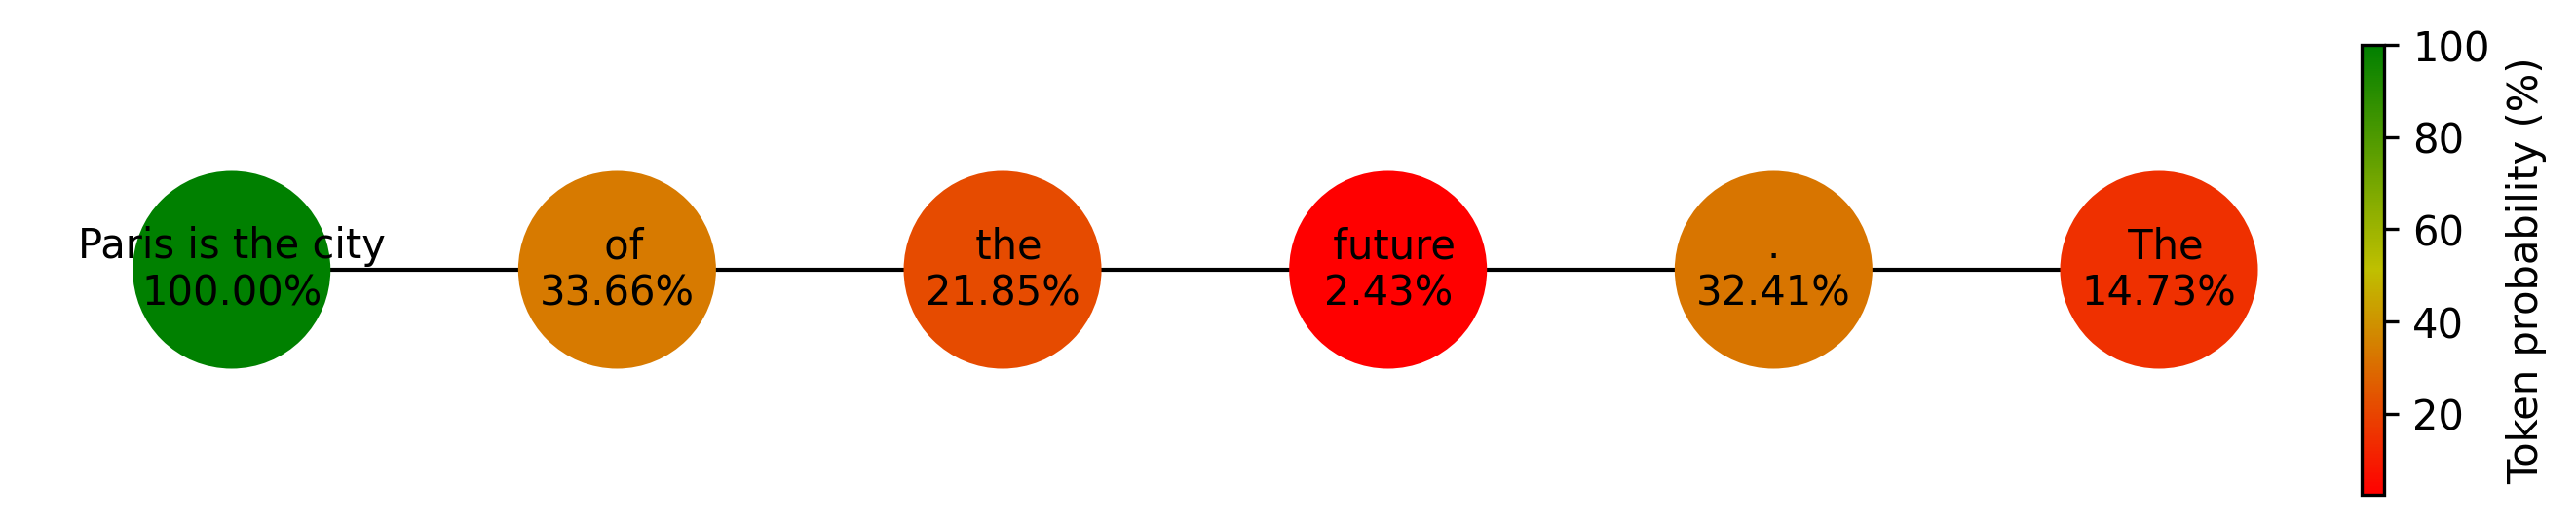

In [7]:
plot_graph(graph, NUMBER_OF_OUTPUTS, 1.5, "token", args='-Grankdir="LR"')

## Beam Search

In [8]:
from tqdm.notebook import tqdm


def greedy_sampling(logits, beams):
    return torch.topk(logits, beams).indices


def beam_search(input_ids, node, bar, length, beams, sampling, temperature=0.1):
    if length == 0:
        return None

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]

    if sampling == "greedy":
        top_token_ids = greedy_sampling(logits, beams)
    elif sampling == "top_k":
        top_token_ids = top_k_sampling(logits, temperature, 20, beams)
    elif sampling == "nucleus":
        top_token_ids = nucleus_sampling(logits, temperature, 0.5, beams)

    for j, token_id in enumerate(top_token_ids):
        bar.update(1)

        # Compute the softmax of the logits
        probabilities = torch.softmax(logits, dim=-1)

        # Compute the score of the predicted token
        token_score = torch.log(probabilities[token_id])
        cumulative_score = graph.nodes[node]["cumscore"] + token_score.item()

        # Add the predicted token to the list of input ids
        new_input_ids = torch.cat(
            [input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=-1
        )

        # Add node and edge to graph
        token = tokenizer.decode(token_id, skip_special_tokens=True)

        current_node = list(graph.successors(node))[j]
        graph.nodes[current_node]["tokenscore"] = np.exp(token_score.item()) * 100
        graph.nodes[current_node]["cumscore"] = cumulative_score
        graph.nodes[current_node]["sequencescore"] = (
            1 / (len(new_input_ids.squeeze())) * cumulative_score
        )
        graph.nodes[current_node]["token"] = token + f"_{length}_{j}"

        # Recursive call
        beam_search(
            new_input_ids, current_node, bar, length - 1, beams, sampling, temperature
        )


def get_best_sequence(graph):
    """
    Get the best sequence of tokens and its maximum score.

    Parameters:
        graph (nx.DiGraph): The graph representing the sequences.

    Returns:
        tuple: A tuple containing the best sequence and its maximum score.
    """
    # Create a list of leaf nodes
    leaf_nodes = [node for node in graph.nodes() if graph.out_degree(node) == 0]

    # Get the leaf node with the highest sequencescore
    max_score_node = max(
        leaf_nodes, key=lambda node: graph.nodes[node]["sequencescore"]
    )

    # Retrieve the sequence of nodes from this leaf node to the root node in a list
    path = nx.shortest_path(graph, source=0, target=max_score_node)

    # Return the string of token attributes of this sequence
    sequence = "".join([graph.nodes[node]["token"].split("_")[0] for node in path])

    return sequence, graph.nodes[max_score_node]["sequencescore"]

In [9]:
# Parameters
length = NUMBER_OF_OUTPUTS
beams = 2

# Create a balanced tree with height 'length' and branching factor 'k'
graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph())
bar = tqdm(total=len(graph.nodes))

# Add 'tokenscore', 'cumscore', and 'token' attributes to each node
for node in graph.nodes:
    graph.nodes[node]["tokenscore"] = 100
    graph.nodes[node]["cumscore"] = 0
    graph.nodes[node]["sequencescore"] = 0
    graph.nodes[node]["token"] = text

# Start generating text
beam_search(input_ids, 0, bar, length, beams, "greedy", temperature=0.1)

sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

  0%|          | 0/63 [00:00<?, ?it/s]

Generated text: Paris is the city of history and culture.


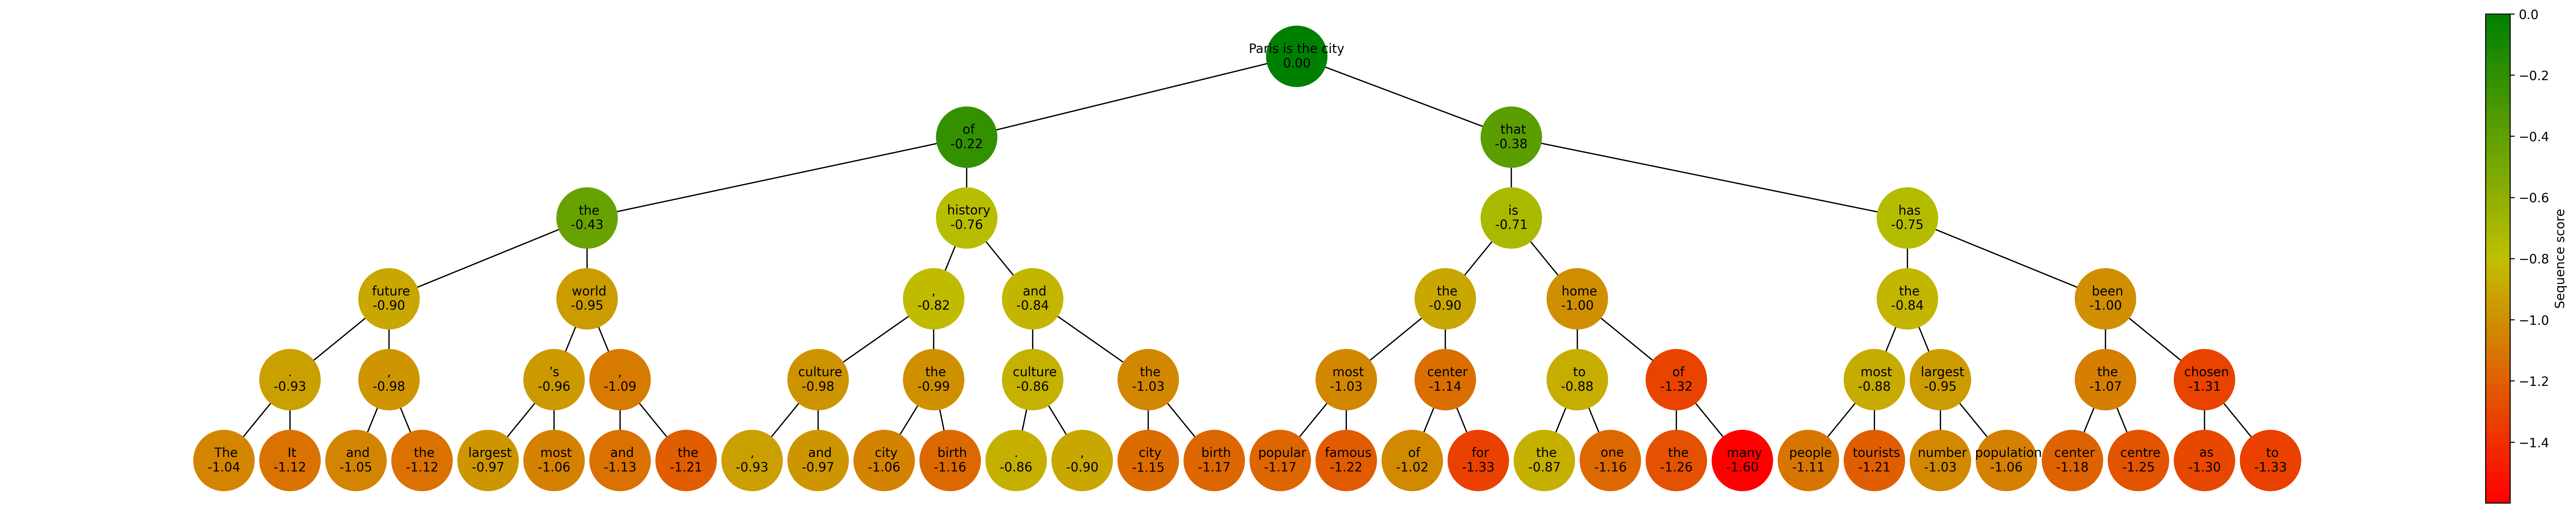

In [10]:
# Plot graph
plot_graph(graph, length, beams, "sequence")

## Top-k sampling

In [11]:
def top_k_sampling(logits, temperature, top_k, beams, plot=True):
    """
    Perform top-k sampling on the logits.

    Parameters:
        logits (torch.Tensor): Logits representing token probabilities.
        temperature (float): Temperature parameter to control the sampling randomness.
        top_k (int): Number of top tokens to keep.
        beams (int): Number of tokens to sample.
        plot (bool, optional): Whether to plot the probability distribution. Defaults to True.

    Returns:
        torch.Tensor: Indices of the sampled tokens.
    """
    if top_k < 1:
        raise ValueError("top_k must be greater than or equal to 1")
    if beams <= 0 or beams > top_k:
        raise ValueError("beams must be a positive integer less than or equal to top_k")

    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    new_logits = torch.clone(logits)
    new_logits[indices_to_remove] = float("-inf")

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(new_logits / temperature, dim=-1)

    # Sample n tokens from the resulting distribution
    next_tokens = torch.multinomial(probabilities, beams)

    return next_tokens


# Start generating text
beam_search(input_ids, 0, bar, length, beams, "top_k", 1)

In [12]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: Paris is the city where I live, and


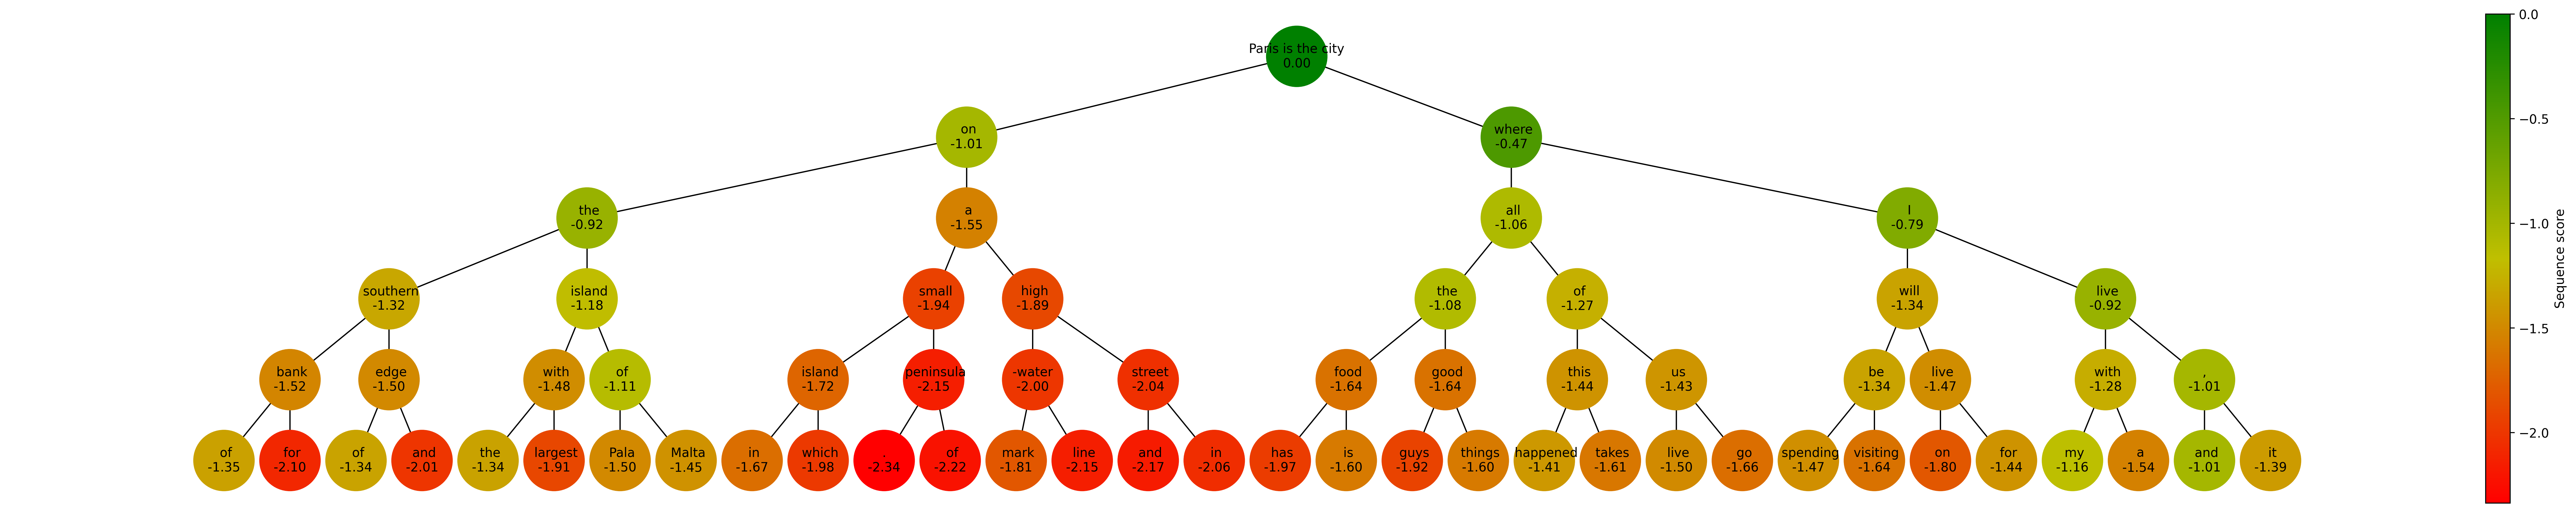

In [13]:
# Plot graph
plot_graph(graph, length, beams, "sequence")

## Nucleus sampling

In [14]:
def nucleus_sampling(logits, temperature, p, beams, plot=True):
    """
    Perform nucleus sampling on the logits.

    Parameters:
        logits (torch.Tensor): Logits representing token probabilities.
        temperature (float): Temperature parameter to control the sampling randomness.
        p (float): Probability threshold for nucleus sampling (0 < p <= 1).
        beams (int): Number of tokens to sample.
        plot (bool, optional): Whether to plot the probability distribution. Defaults to True.

    Returns:
        torch.Tensor: Indices of the sampled tokens.
    """
    if not 0 < p <= 1:
        raise ValueError("p must be in the range (0, 1]")
    if beams <= 0:
        raise ValueError("beams must be a positive integer")

    # Sort the probabilities in descending order and compute cumulative probabilities
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    exp_logits = torch.exp(sorted_logits / temperature)
    cumulative_probabilities = torch.cumsum(exp_logits, dim=-1)

    # Create a mask for probabilities that are in the top-p
    mask = cumulative_probabilities < p

    # If there's not an index where cumulative_probabilities < p, we use the top n tokens instead
    if mask.sum() > beams:
        top_p_index_to_keep = torch.where(mask)[0][-1].detach().cpu().tolist()
    else:
        top_p_index_to_keep = beams

    # Only keep top-p indices
    indices_to_remove = sorted_indices[top_p_index_to_keep:]
    sorted_logits[indices_to_remove] = float("-inf")

    # Sample n tokens from the resulting distribution
    probabilities = torch.softmax(sorted_logits, dim=-1)
    next_tokens = torch.multinomial(probabilities, beams)

    return next_tokens


# Start generating text
beam_search(input_ids, 0, bar, length, beams, "nucleus", 1)

In [15]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: Paris is the city of history and culture.


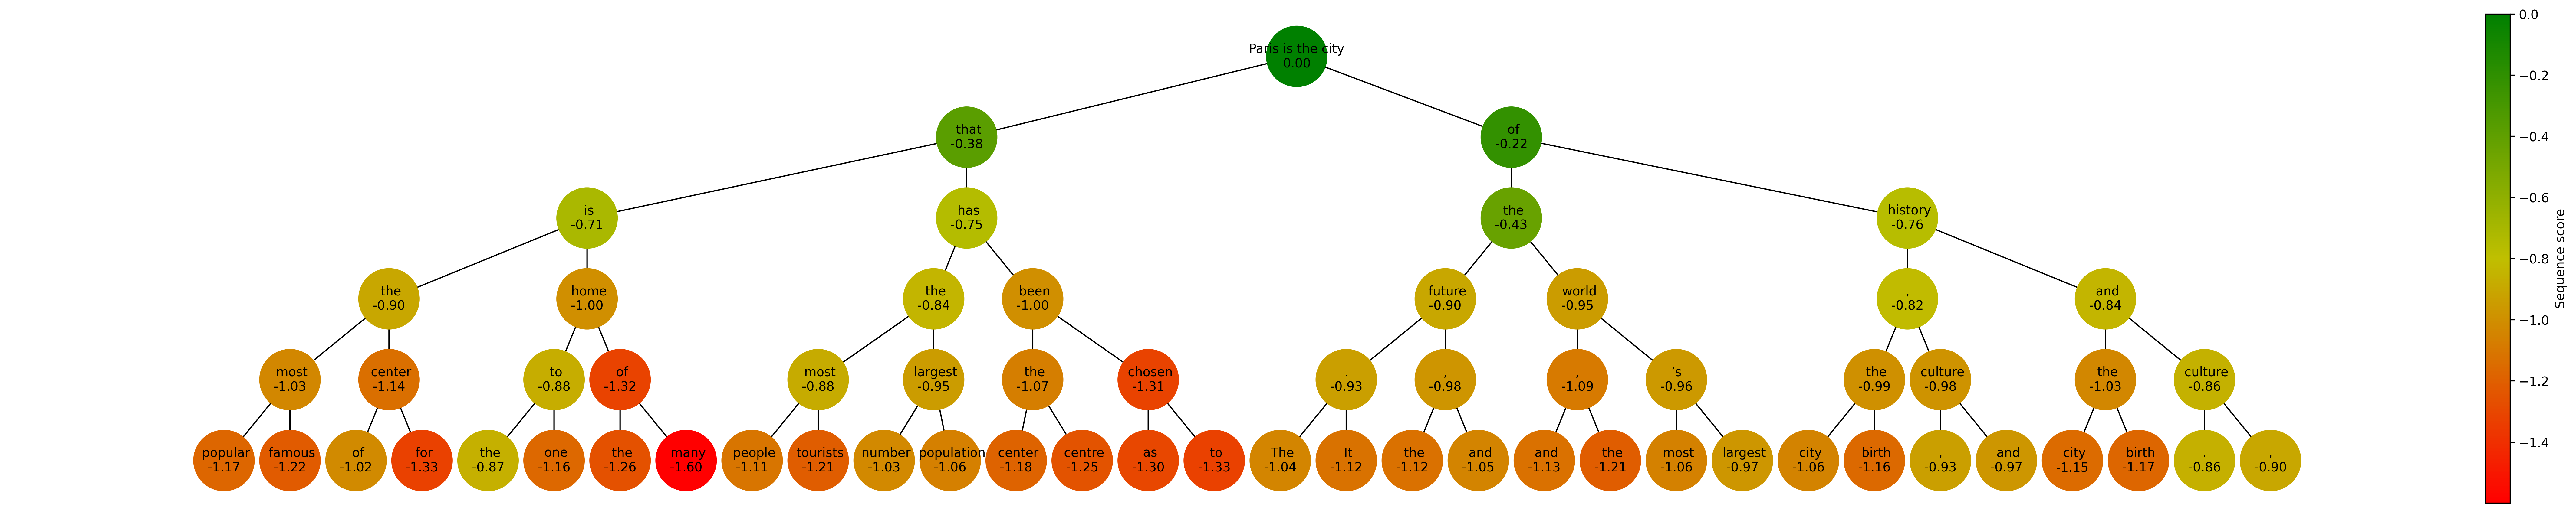

In [16]:
# Plot graph
plot_graph(graph, length, beams, "sequence")